## Needle Search

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from random import randrange
import cv2
import math

In [2]:
class Vertex:
    def __init__(self, location, parent):
        self.location =  location
        self.parent = parent


In [3]:
def gen_color_map(height, width, goal_location, goal_radius):

    # create a board defaultly white
    color_map = np.full(shape=[height, width, 3], fill_value=255, dtype=np.uint8)

    # create a blue circle around the goal
    color_map, dummy = expand_goal(color_map, [0,255,255], goal_location, goal_radius, width , height)
    color_map, goal_points = expand_goal(color_map, [0,0,255], goal_location, goal_radius//2, width , height)
    
    plot_obstcles(color_map)
    return color_map, goal_points

In [4]:
def plot_obstcles(color_map):
    for i in range(100, 200):
        for j in range(100, 300):
            color_map[j][i] = [255, 0, 0]

    for i in range(200, 800):
        for j in range(400, 600):
            color_map[j][i] = [255, 0, 0]

    for i in range(480, 520):
        for j in range(700, 900):
            color_map[j][i] = [255, 0, 0]

In [5]:
# draw a circle (red in numpy, blue in opencv) to represent the acceptable goal zone
def expand_goal(color_map, color, goal_location, radius, width, height):

    x = goal_location[0]
    y = goal_location[1]

    goal_points = []

    # generate the range of the circle and bound check with the dimensions of the board
    x_range = range(x-radius, x+radius+1)

    for x_i in x_range:

        # we're going to effectively integrate over the x range to cover the area of the goal
        y_lower_limit = np.floor(-np.sqrt(radius**2-(x_i-x)**2) + y)
        y_upper_limit = np.ceil(np.sqrt(radius**2-(x_i-x)**2) + y)

        y_range = np.arange(y_lower_limit, y_upper_limit+1)

        for y_i in y_range:
            if (x_i >= 0 and x_i < width) and (y_i >= 0 and y_i < height):
                color_map[int(y_i)][int(x_i)] = color
                goal_points.append((int(x_i), int(y_i)))

    return color_map, goal_points

In [6]:
# pass in the new vertex and list of allverteces generated, 
# and return the vertex in the lost which has the closest location
def get_closest_vertex(new_vertex, verteces):
    
    closest_vertex = verteces[0]
    closest_distance = np.Infinity

    for vertex in verteces:
        distance = np.sqrt((new_vertex.location[0]-vertex.location[0])**2 + (new_vertex.location[1]-vertex.location[1])**2)

        if distance < closest_distance:
            closest_distance = distance
            closest_vertex = vertex

    return closest_vertex, distance

In [7]:
# draw the edge between two verteces on the map
def draw_edge(point1, point2, color, color_map):

    point1 = np.array(point1[:2], dtype = np.int32)
    point2 = np.array(point2[:2], dtype = np.int32)

    cv2.line(color_map, point1, point2, color ,2)        

In [8]:
def draw_path(path, color, color_map):

    if len(path) != 0:
        po = path[0]
        for pi in path[1:]:
            draw_edge(po, pi, color, color_map)
            po = pi

In [9]:
# generate a set of points which represent points along an edge
# direction line points moves in is from point p1 to p2
def generate_line_points(p1, p2):

    x1 = p1[0]
    y1 = p1[1]

    x2 = p2[0]
    y2 = p2[1]

    points = []

    # check for the case of a vertical line
    if x1 == x2:
        if y2 > y1:
            for y in range(y1, y2+1):
                points.append((x1, y))
            return points
        else:
            for y in range(y2, y1+1):
                points.insert(0,(x1, y))
            return points

    else:
        # change the line formula to make sure the line equations are going from left to right
        # but we need to make sure that we're inserting points in the direction 
        # from the previous node to the new node
        if x2 > x1:
            
            m = (y2-y1)/(x2-x1)
            b = y1-m*x1
            lin_func = lambda x: m*x+b

            for x_i in range(x1, x2+1):
                y = lin_func(x_i)
                points.append((x_i, math.floor(y)))

            return points

        else:

            m = (y1-y2)/(x1-x2)
            b = y2-m*x2
            lin_func = lambda x: m*x+b

            for x_i in range(x2, x1+1):
                y = lin_func(x_i)
                points.insert(0,(x_i, math.floor(y)))
                
            return points


    

In [10]:
# check to see if the rgb value of the color map is [255, 0, 0]
# which is the obstacle color
def check_point_in_obstacle(point, color_map):
    y = point[1]
    x = point[0]

    if (color_map[y][x][0] == 255 and color_map[y][x][1] == 0 and color_map[y][x][2] == 0):
        return True
    else:
        return False

In [11]:
# pass in the set of the points from p1, the closest vertex
# to p2, the new vertex, and cut off the line if encounters an obstacle
def check_path_in_obstacle(line_points, color_map):

    if len(line_points) > 1:
        for i in range(len(line_points)):
            if check_point_in_obstacle(line_points[i], color_map):
                return line_points[:i-1]

    return line_points

In [12]:
# check to see if the rgb value of the color map is [255, 0, 0]
# which is the obstacle color
def check_point_in_solution(point, color_map):
    y = point[1]
    x = point[0]

    if (color_map[y][x][0] == 0 and color_map[y][x][1] == 0 and color_map[y][x][2] == 255):
        return True
    else:
        return False

In [13]:
# check to see if the line is within range of the goal
def check_path_in_solution(line_points, color_map):
    
    if len(line_points) > 1:
        for i in range(len(line_points)):
            if check_point_in_solution(line_points[i], color_map):


                # this just is to correct some roundingerrors
                # sometimes they cause the path end location to be JUST outside of the goal. 
                # So if there is a next spot in the path, report it just so we end up in the goal
                try:
                    line_points[i+1]
                except:
                    return line_points[:i], True
                else:
                    return line_points[:i+1], True


    return line_points, False

In [14]:
# start at the end of the visited verteces, then iterate backwards
# through the parents, and insert them to the beginning of
# the solution path
def generate_solution_path(end_vertex):
    
    curr_vertex = end_vertex
    solution_path = []

    while curr_vertex is not None:
        solution_path.insert(0, curr_vertex.location)
        curr_vertex = curr_vertex.parent

    return solution_path

In [15]:
def generate_accessible_goal_points(location, goal_points, distance_limit):

    accessible_points = []


    # just filter all goal points to the ones which are within reach of the current location
    # distance limit is the tip to tip needle length
    for gp in goal_points:
        
        l_x = location[0]
        l_y = location[1]
        
        g_x = gp[0]
        g_y = gp[1]

        if math.sqrt((l_x - g_x)**2 + (l_y - g_y)**2) <= distance_limit:
            accessible_points.append(gp)


    return accessible_points



In [16]:
# generate a set of path swhich represent the path of a curved needle
def generate_arc_path(needle_length, needle_angle, location, height, width):

    divisions = 40

    d_arc = needle_length/divisions

    path = [location]

    for i in range(divisions):
        x = location[0] + math.cos(location[2])*d_arc
        if x < 0:
            x = 0
        if x >= width:
            x = width-1

        y = location[1] + math.sin(location[2])*d_arc
        if y < 0:
            y = 0
        if y >= height:
            y= height-1
        
        th = location[2] + needle_angle/divisions


        new_location = (int(x), int(y), th)
        path.append(new_location)
        location = new_location
        
    
    return path


## Initialization

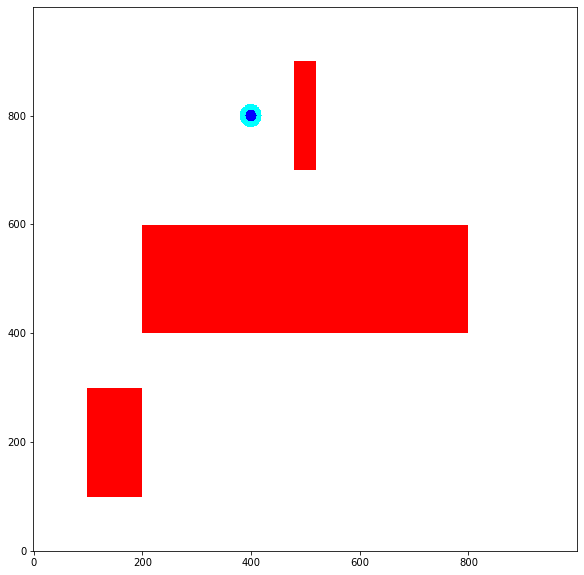

In [17]:
height = 1000
width = 1000

needle_1_len = 400

# initialize the graph
goal_location = (400, 800)
goal_radius = 20
color_map, goal_points = gen_color_map(height, width, goal_location, goal_radius)


plt.figure(figsize=[10,10])
plt.imshow(color_map, origin = 'bottom')

### Check to see if we can get it in the first needle

#### If we assume that the nedle can enter at any angle

1. Check to see if there are any goal points within range of the first needle

2. If yes, then for each gp within range, iterate over every point on the entrance wall and pick the first one that can see the goal unobstructed

3. Return success on the first match

3. We know its unsuccessful when we run out of GPs to search through

#### If we assume the needle can only enter at a zero angle 

1. Check to see if there are any goal points within range of the first needle

2. If yes, then for each gp within range and see if the needle can enter the point unobstructed from the entrance side 

3. Return success on the first match

3. We know its unsuccessful when we run out of GPs to search through

Found Solution


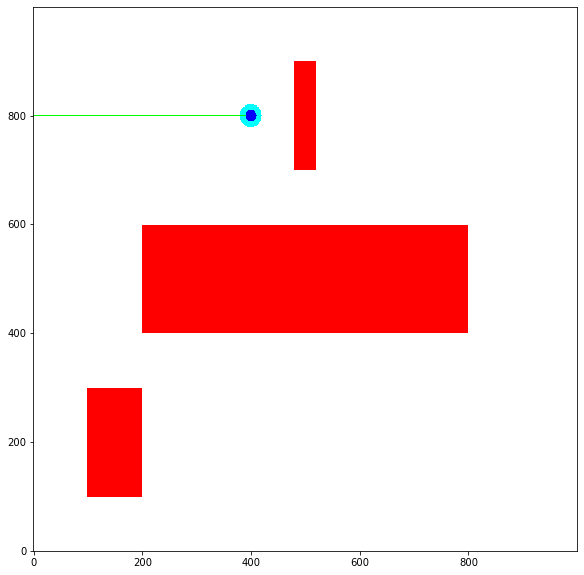

In [18]:
def check_first_needle(needle_1_len, goal_points, color_map):
    
    found_solution = False

    # Iterate over the entrance pints on the left border
    # Return the first path from the entrance point to any goal point
    # within range, which is unobstructed by an obstacle
    for gp in goal_points:

        if gp[0] < needle_1_len:

            entrance_point = [0,gp[1]]

            line_path = generate_line_points(gp, entrance_point)
            obst_path = check_path_in_obstacle(line_path, color_map)

            if len(line_path) == len(obst_path):
                print('Found Solution')
                found_solution =  True
                draw_edge(gp, entrance_point, [0,255,0], color_map)
                plt.figure(figsize=(10, 10))
                plt.imshow(color_map, origin = 'bottom')
                break

    if not found_solution:
        print('Cannot be reached within the first needle')

if goal_location[0] - goal_radius > needle_1_len:
    print('Not possible within first needle')
else:
    check_first_needle(needle_1_len, goal_points, color_map)

## Re-Initialization

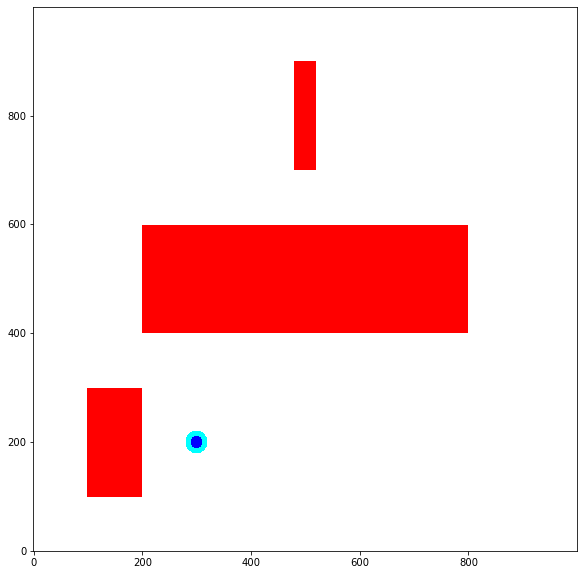

In [19]:
height = 1000
width = 1000

needle_1_len = 400
needle_2_len = 300
# initialize the graph
goal_location = (300, 200)
goal_radius = 20
color_map, goal_points = gen_color_map(height, width, goal_location, goal_radius)

search_radius = goal_radius + needle_2_len


plt.figure(figsize=[10,10])
plt.imshow(color_map, origin = 'bottom')

### Check to see if we can get it in 2 needles

If we have a 2 needle success, then we know that that there is the large needle 

Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
Found Solution
No solution found


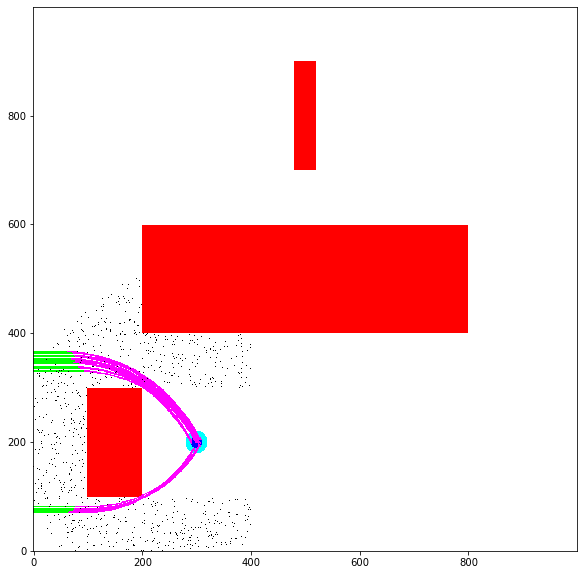

In [20]:
def second_needle_search(needle_2_len, goal_location, color_map):

    i_limit = 3000
    i = 0
    found_solution = False

    locations = []

    while i < i_limit:
        # generate randompoints in the intersection of the goal area and the first needle accessible space
        x_rand = randrange(max(0,(goal_location[0] - search_radius)), needle_1_len)
        y_rand = randrange(max(0,(goal_location[1] - search_radius)), min((goal_location[1] + search_radius), height))

        location = (x_rand, y_rand, 0)
        # if location in locations:
        #     continue


        # if in obstacle, regen point
        if check_point_in_obstacle(location, color_map):
            continue

        # check to make sure this spot is not behind an obstacle
        ep = (0, location[1])
        entrant_path = generate_line_points(location, ep)
        verified_entrant_path = check_path_in_obstacle(entrant_path, color_map)
        if len(entrant_path) != len(verified_entrant_path):
            continue


        # make sure that were generating points in a circular pattern
        distance = math.sqrt((x_rand-goal_location[0])**2 + (y_rand-goal_location[1])**2)
        if distance <= search_radius:
            
            color_map[y_rand][x_rand] = (0,0,0) 


            # so we know that this location is accessible to both the entrance and goal
            # independently, but not necessarily simultaneously
            angles = [math.pi/3, -math.pi/3]
            # angles = [0]
            for angle in angles:
                path = generate_arc_path(needle_2_len, 
                                            angle, 
                                            location, 
                                            height, width)

                path = check_path_in_obstacle(path, color_map)
                path, found_solution = check_path_in_solution(path, color_map)

                if found_solution:
                    print("Found Solution")
                    draw_edge(ep, location, (0,255,0), color_map)
                    draw_path(path, (255,0,255), color_map)
                    # return


            locations.append(location)
            i += 1

    print("No solution found")


if goal_location[0] - search_radius > needle_1_len:
    print('Not possible within 2 needles')
else:
    second_needle_search(needle_2_len, goal_location, color_map)
    plt.figure(figsize=(10,10))
    plt.imshow(color_map, origin='bottom')

### 3 needle search

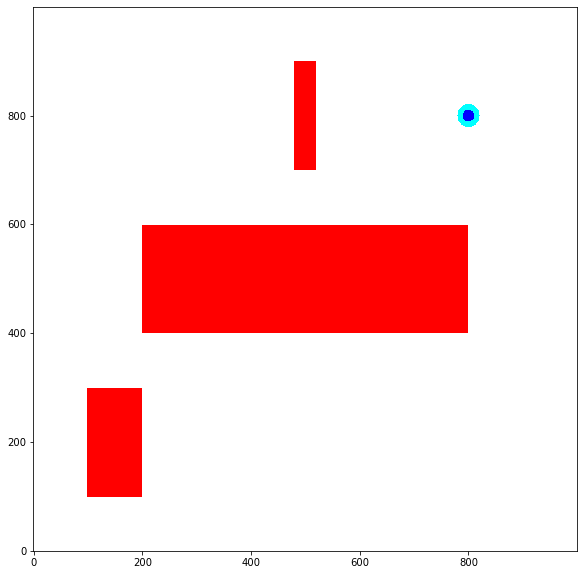

In [21]:
height = 1000
width = 1000

needle_1_len = 400
needle_2_len = 300
needle_3_len = 300
# initialize the graph
goal_location = (800, 800)
goal_radius = 20
color_map, goal_points = gen_color_map(height, width, goal_location, goal_radius)

search_radius = goal_radius + needle_2_len + needle_3_len


plt.figure(figsize=[10,10])
plt.imshow(color_map, origin = 'bottom')

0:Attempting to join needle 1 and needle 2 at (223, 677, 0)
1:Attempting to join needle 1 and needle 2 at (247, 842, 0)
2:Attempting to join needle 1 and needle 2 at (389, 835, 0)
3:Attempting to join needle 1 and needle 2 at (285, 668, 0)
4:Attempting to join needle 1 and needle 2 at (222, 975, 0)
5:Attempting to join needle 1 and needle 2 at (335, 944, 0)
6:Attempting to join needle 1 and needle 2 at (332, 952, 0)
7:Attempting to join needle 1 and needle 2 at (375, 806, 0)
8:Attempting to join needle 1 and needle 2 at (187, 710, 0)
9:Attempting to join needle 1 and needle 2 at (224, 998, 0)
10:Attempting to join needle 1 and needle 2 at (394, 923, 0)
11:Attempting to join needle 1 and needle 2 at (184, 817, 0)
12:Attempting to join needle 1 and needle 2 at (196, 792, 0)
13:Attempting to join needle 1 and needle 2 at (292, 932, 0)
14:Attempting to join needle 1 and needle 2 at (298, 989, 0)
15:Attempting to join needle 1 and needle 2 at (230, 740, 0)
16:Attempting to join needle 1 and

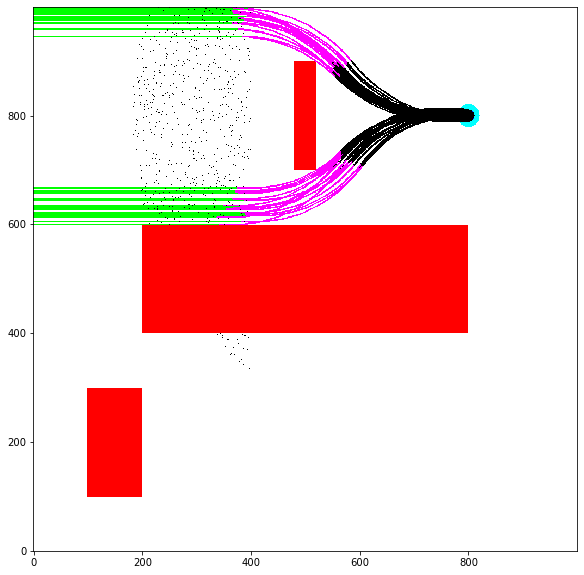

In [22]:
def third_needle_search(search_radius, goal_location, color_map):

    i_limit = 2000
    i = 0
    found_solution = False

    mid_locations = []


    ## search midspace
    while i < i_limit:
        # generate a random point which should be where the first needle connects to the second
        # bounded by the range of the first needle, and the total search radius from the goal
        x_rand = randrange(max(0,(goal_location[0] - search_radius)), needle_1_len)
        y_rand = randrange(max(0,(goal_location[1] - search_radius)), min((goal_location[1] + search_radius), height))

        mid_location = (x_rand, y_rand, 0)
        # if location in locations:
        #     continue


        # if in obstacle, regen point
        if check_point_in_obstacle(mid_location, color_map):
            continue


        # check to make sure this spot is not behind an obstacle
        ep = (0, mid_location[1])
        entrant_path = generate_line_points(mid_location, ep)
        verified_entrant_path = check_path_in_obstacle(entrant_path, color_map)
        if len(entrant_path) != len(verified_entrant_path):
            continue

        

        # make sure that were generating points in a circular 
        # pattern where the second needle connects to the first 
        # and could possibly connect to the third
        distance = math.sqrt((x_rand-goal_location[0])**2 + (y_rand-goal_location[1])**2)
        if distance <= search_radius:
            print(f'{i}:Attempting to join needle 1 and needle 2 at {mid_location}')
            
            color_map[y_rand][x_rand] = (0,0,0) 
        
            # GENERATE PATHS Startting from the needle 1 - needle 2 junction
            # towards the needle 2 - needle 3 junction
            curves = [math.pi/3, -math.pi/3]
            for curve in curves:
                path = generate_arc_path(needle_2_len, 
                                            curve, 
                                            mid_location, 
                                            height, width)
                path = check_path_in_obstacle(path, color_map)

                for p in range(len(path)):
                    for c in curves:
                        inner_path = generate_arc_path(needle_3_len, 
                                            c, 
                                            path[p], 
                                            height, width)
                        inner_path = check_path_in_obstacle(inner_path, color_map)
                        inner_path, found_solution = check_path_in_solution(inner_path, color_map)
                    

                        if found_solution:
                            print("Found Solution")
                            draw_edge(ep, mid_location, (0,255,0), color_map)
                            draw_path(path[:p+1], (255,0,255), color_map)
                            draw_path(inner_path, (0,0,0), color_map)

                            # return


            mid_locations.append(mid_location)
            i += 1


    print("No solution found")


if goal_location[0] - search_radius > needle_1_len:
    print('Not possible within 3 needles')
else:
    third_needle_search(search_radius, goal_location, color_map)
    plt.figure(figsize=(10,10))
    plt.imshow(color_map, origin='bottom')